# Costa Rican Household Poverty Level Prediction

# 哥斯达黎加家庭贫困水平预测

这个比赛的目的是，基于历史数据，使用机器学习方法来预测家庭的贫困水平．数据不大，非常适合单机操作．

## Data Explanation

比赛提供了两组数据**train.csv**和**test.csv**:

- 每一行代表一个家庭成员的数据，（一个家庭可以有多个成员组成，只对户主进行预测）
- train.csv,包含１４３列，含ID,Target和141个特征
- test.csv,包含１４２列，不含Target
- 户主代表一个家庭，只对户主进行评分

关键字段：

- Id : 每一个样本数据的一个标识
- idhogar : 每一个家庭的唯一标识，拥有相同标识样本属于一个家庭
- parentesco1 : 标识该成员是否为户主
- Target : 家庭的贫困情况

   - 1 = extreme poverty 
   - 2 = moderate poverty 
   - 3 = vulnerable households 
   - 4 = non vulnerable households


*!*，原始数据是每个家庭成员的信息，最后提交的结果是每个家庭的贫困情况.

 问题就简单介绍完了．下面开对数据进行探索分析

# Exploratory Data Analysis(EDA)

用到的python库：

- pandas
- numpy
- matplotlib
- seaborn
- sklearn

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# set default params
%matplotlib inline
plt.rcParams['font.size'] = 18
pd.options.display.max_columns = 10

import warnings
warnings.filterwarnings('ignore')

数据概览

In [2]:
train = pd.read_csv('../train.csv')
test = pd.read_csv('../test.csv')
feature_desp = pd.read_csv('../feature_description.csv', error_bad_lines=False)
feature_desp = feature_desp.set_index('F_name')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,...,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,...,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,...,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,...,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,...,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,...,1.777778,1.0,121.0,1369,4


In [3]:
#特征的描述信息
feature_desp.tail()

,description
F_name,
SQBhogar_nin,hogar_nin squared
SQBovercrowding,overcrowding squared
SQBdependency,dependency squared
SQBmeaned,square of the mean years of education of adul...
agesq,Age squared


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


# [int]类型特征unique value统计

Text(0.5, 1.0, 'Count of Unique Values in Integer Columns')

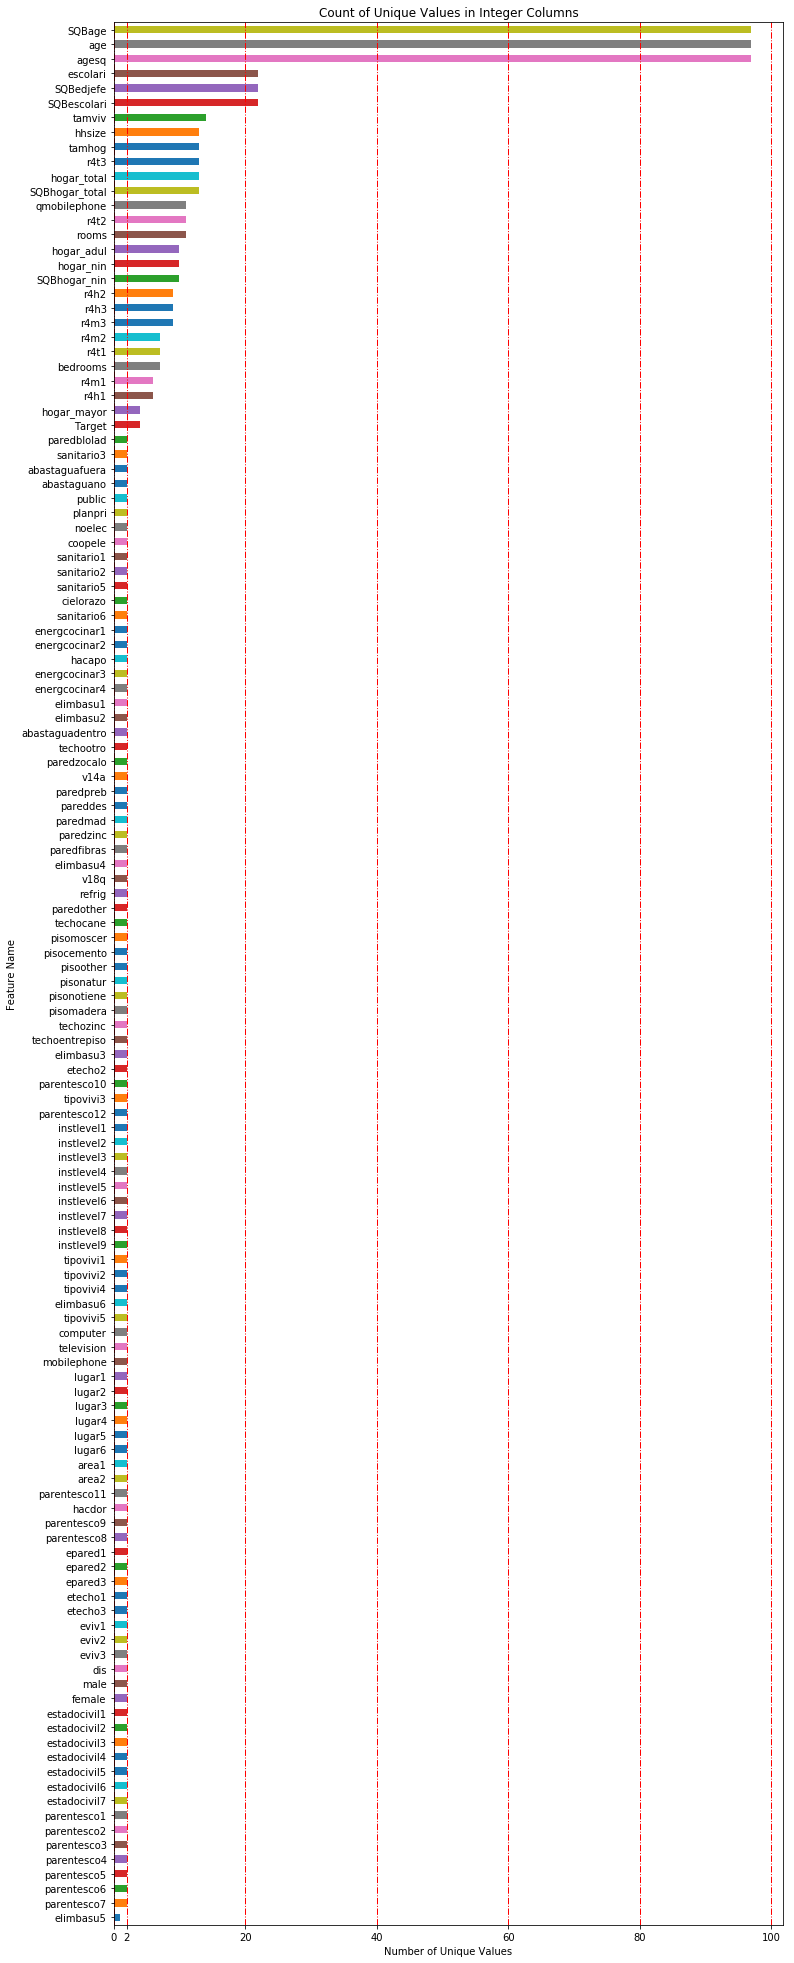

In [6]:
train.select_dtypes(['int']).nunique().sort_values().plot(kind='barh',figsize=(12, 35))
plt.grid(axis='x', color='r', linestyle='-.', linewidth=1)
# 位置＆标签
locations = np.array([0,2,20,40,60,80,100])
labels = [0,2,20,40,60,80,100]
plt.xticks(locations, labels)
plt.xlabel('Number of Unique Values')
plt.ylabel('Feature Name')
plt.title('Count of Unique Values in Integer Columns')

可以发现有些特征的count(unique_value) = 2,这些特征只有两个值，0/1,比如，parentesco1用来标识这个人是否为户主，０:不是，１：是．

下面继续观察特征为浮点数类型变量的KDE核密度估计，同时根据target映射到不同的颜色．
由于核密度估计方法不利用有关数据分布的先验知识，对数据分布不附加任何假定，是一种从数据样本本身出发研究数据分布特征的方法。

# KDE(float)特征

特征描述

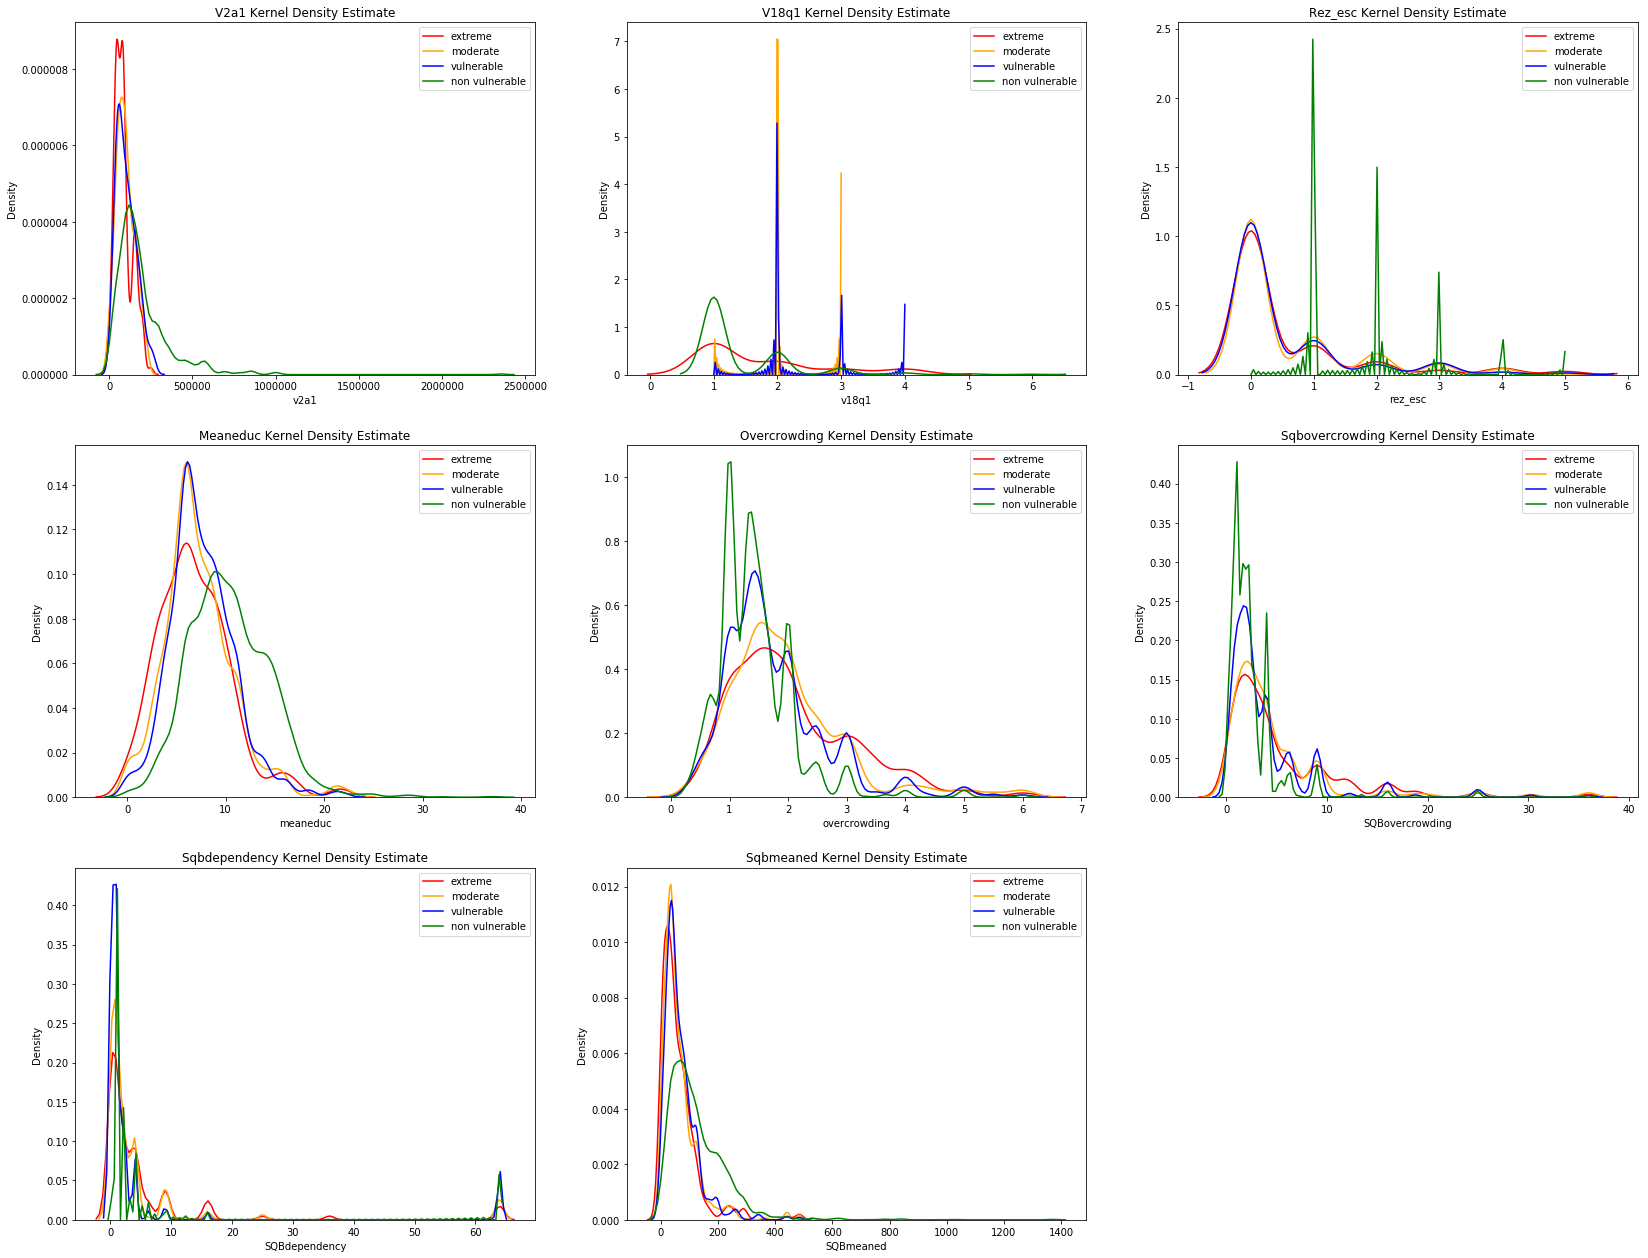

In [7]:
from collections import OrderedDict

plt.figure(figsize = (28, 12))

# Color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
label_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 
                               4: 'non vulnerable'})

# float columns
for i, col in enumerate(train.select_dtypes(['float'])):
    ax = plt.subplot(4, 3, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # 核密度估计
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = label_mapping[poverty_level])
        
    plt.title('%s Kernel Density Estimate'%(col.capitalize()))
    plt.xlabel('%s'%col)
    plt.ylabel('Density')

plt.subplots_adjust(top = 2)

# (object)

In [8]:
# (object)
train.select_dtypes(['object']).head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


 `Id` 和 `idhogar` 是家庭成员和家庭的标识符．
 下面是其他三个特征：

In [9]:
pd.options.display.max_colwidth = 200
pd.options.display.large_repr = 'truncate'

feature_desp.loc[['dependency','edjefe','edjefa']]

,description
F_name,
dependency,Dependency rate calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)
edjefe,years of education of male head of household based on the interaction of escolari (years of education) head of household and gender yes=1 and no=0
edjefa,years of education of female head of household based on the interaction of escolari (years of education) head of household and gender yes=1 and no=0


　　现在已经简单了解了一下数据，数据中的有些特征是家庭的信息，有的是家庭成员的个人信息．还有一些特征包含一些混合信息，比如上面的三个特征，有int和object两种，根据特征的描述信息，yes=1,no=0,dependency没有提示yes/no代表什么意思，但是这个特征记录的是，家中[19~64]的人的数量．所以姑且也把yes=1,no=0.

In [10]:
train.dependency = train.dependency.replace({"yes": 1, "no": 0}).astype(np.float64)
train.edjefa = train.edjefa.replace({"yes": 1, "no": 0}).astype(np.float64)
train.edjefe = train.edjefe.replace({"yes": 1, "no": 0}).astype(np.float64)

### KDE(kernel density estimate)

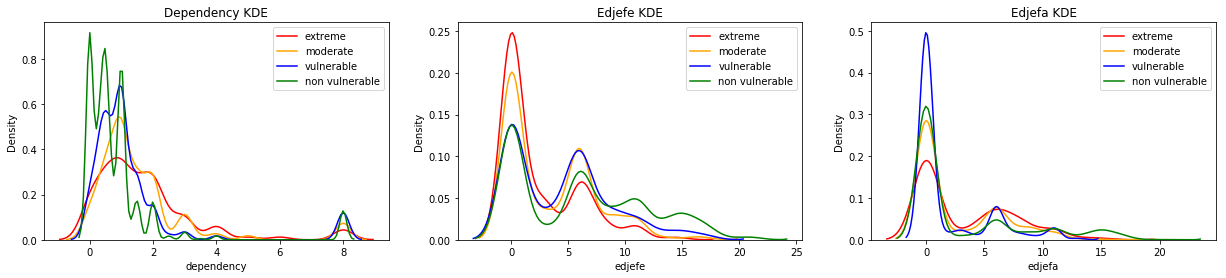

In [11]:
plt.figure(figsize = (21, 4))
for i, col in enumerate(['dependency','edjefe','edjefa']):
    ax = plt.subplot(1, 3, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # 核密度估计
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = label_mapping[poverty_level])
        
    plt.title('%s KDE'%(col.capitalize()))
    plt.xlabel('%s'%col)
    plt.ylabel('Density')

plt.subplots_adjust()

# Distribution of Target

　　Target是每一个家庭的标记信息，接下来观察一下Target的分布信息，需要筛选出`parentecso1 == 1`的数据，parentecso = 1,表示该名家庭成员为一家之主,(一个家庭只有一个一家之主),所以parentecso = 1的家庭成员的target即代表：家庭的target.

Text(0.5, 1.0, 'Poverty Level Distribution')

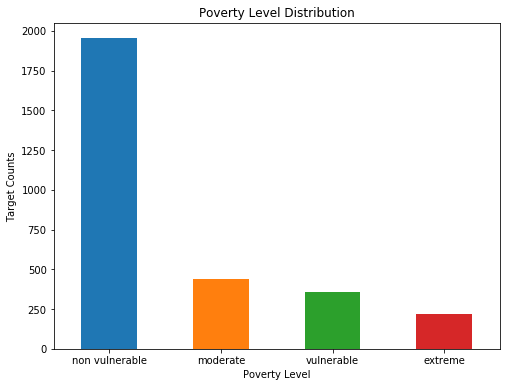

In [12]:
target_counts = train.loc[train.parentesco1 == 1].Target.value_counts()
target_counts.plot.bar(figsize = (8, 6),rot = 0)
plt.xlabel('Poverty Level')
plt.ylabel('Target Counts')
plt.xticks(np.arange(0, 4, 1), ['non vulnerable','moderate','vulnerable','extreme'])
plt.title('Poverty Level Distribution')

很明显这是类别不平衡问题，属于extreme类的家庭比其他类别的总和还多．

## Addressing Wrong Target(纠错标签)

　　正常情况是：如果一个家庭的Target是extreme,即为户主身份的成员Target为extreme,那么这个家庭中所有成员的Target应该是一致的extreme.但是，有些异常情况，属于同一个家庭的成员有多个不同的target,这种异常可能是人为的或者其他因素造成的．
　　但是这个异常，事实上不用去修正，只要在训练模型时还是以户主的Target为准的．如果要修正这个的话，先要对数据进行分组，根据idhogar进行分组,检查Target是否一致．

In [13]:
# 家庭成员Target标记一致的家庭
norm = train.groupby(by = 'idhogar')['Target'].apply(lambda x:x.nunique() == 1)
# 有问题的
# num_unique != 1
unnorm = norm[norm == False]

Checkout one unnorm example,家庭编号：0172ab1d9

In [14]:
train[train['idhogar'] == unnorm.index[0]][['idhogar', 'parentesco1', 'Target']]

,idhogar,parentesco1,Target
7651,0172ab1d9,0,3
7652,0172ab1d9,0,2
7653,0172ab1d9,0,3
7654,0172ab1d9,1,3
7655,0172ab1d9,0,2


`parentesco1 == 1`的家庭成员为户主，户主的target即代表整个家庭的Target,正常情况下，其他家庭成员的Target应该与户主相同Target = 3.因此可以根据，户主的Target来修正其他家庭成员的Target.大多数正常情况下是这样，但是就怕有意外情况，这家没有户主，而且家庭成员Target不一致，这个时候怎么办，怎么确定这个家庭的Target.下面先检查一下有没有没有户主的情况．

# Check head of household

In [15]:
(train.groupby(by = 'idhogar')['parentesco1'].sum() < 1).value_counts()

False    2973
True       15
Name: parentesco1, dtype: int64

15个家庭是没有户主的状态．下面是这个１５个家庭的部分信息

In [16]:
# groupby idhogar , count parentesco1
count_head_of_household = train.groupby(by = 'idhogar')['parentesco1'].sum()

# select don't have head of household family member
households_no_head = train.loc[train.idhogar.isin(count_head_of_household[count_head_of_household == 0].index),:]    

households_no_head[['idhogar', 'parentesco1', 'Target']].sort_values('idhogar')

,idhogar,parentesco1,Target
7706,03c6bdf85,0,3
7705,03c6bdf85,0,3
4935,09b195e7a,0,3
7086,1367ab31d,0,3
9497,1bc617b23,0,3
5396,374ca5a19,0,3
5391,61c10e099,0,3
7438,6b1b2405f,0,4
7439,6b1b2405f,0,4
7440,6b1b2405f,0,4


上面是１５个家庭２３个家庭成员的部分信息,虽然这些家庭没有标记户主，但是家庭成员的target都是一致的．
下面是这１５个没有户主家庭成员的target,unique_values信息．

In [17]:
households_no_head.groupby(by = 'idhogar')['Target'].apply(lambda x:x.nunique())

idhogar
03c6bdf85    1
09b195e7a    1
1367ab31d    1
1bc617b23    1
374ca5a19    1
61c10e099    1
6b1b2405f    1
896fe6d3e    1
a0812ef17    1
ad687ad89    1
b1f4d89d7    1
bfd5067c2    1
c0c8a5013    1
d363d9183    1
f2bfa75c4    1
Name: Target, dtype: int64

　　看来是多虑了，这１５个没有户主的家庭，家庭成员的Target标记是相同的．接下就只用纠正那些标记了户主的家庭，家庭成员有多种不同Target的数据．原则就是，家庭成员的Target应与户主相同．
  
 # Fix wrong target

In [18]:
# unnorm.index : 不正常的家庭idhogar
for household_id in unnorm.index:
    # 找到户主的Target
    real_target = int(train[(train.idhogar == household_id) & (train.parentesco1 == 1)].Target)
    # 修正household的Target
    train.loc[train.idhogar == household_id, 'Target'] = real_target
# check check
(train.groupby(by = 'idhogar')['Target'].apply(lambda x:x.nunique()) > 1).value_counts()

False    2988
Name: Target, dtype: int64

## meaneduc,Target,gender之间的联系

下面通过箱线图来观察一下，不同年龄人群受教育程度与贫困情况之间的联系

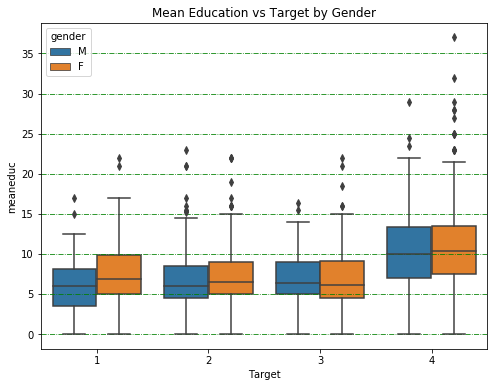

In [19]:
# Extract the labels
label_df = train[train['parentesco1'] == 1].copy()

# Create a gender mapping
label_df['gender'] = label_df['male'].replace({1: 'M', 0: 'F'})

plt.figure(figsize = (8, 6))

# Boxplot
sns.boxplot(x = 'Target', y = 'meaneduc', hue = 'gender', data = label_df)
plt.title('Mean Education vs Target by Gender')
plt.grid(axis = 'y', color = 'green', linestyle ='-.')

　　可以发现贫困级别为１:extreme极度贫困的家庭，无论是男性还是女性户主平均受教育程度都是最低的．
随着受教育程度的升高，贫困水平有所下降，可以发现edu和povert是呈现反比的．
无论哪个级别贫困家庭，户主为女性的平均受教育程度要略高与男性户主，
下面是根据性别和贫困水平的分组统计信息．

In [20]:
label_df.groupby(['gender', 'Target'])['meaneduc'].agg(['mean', 'count'])

mean  count
gender Target                  
F      1        7.332627    118
       2        7.371026    195
       3        7.075253    132
       4       10.575066    717
M      1        5.965545    104
       2        6.704251    247
       3        6.983483    223
       4       10.149090   1234

violin plot 是 box plot和数据分布密度的组合图，Box Plots在数据显示方面受到限制，因为它们的视觉简洁性往往会隐藏有关数据中值如何分布的重要细节。例如，使用Box Plots，您无法查看分布是双峰还是多峰。中心的粗黑条表示四分位数范围，从中延伸的细黑线表示95％置信区间，中间白点是中位数．

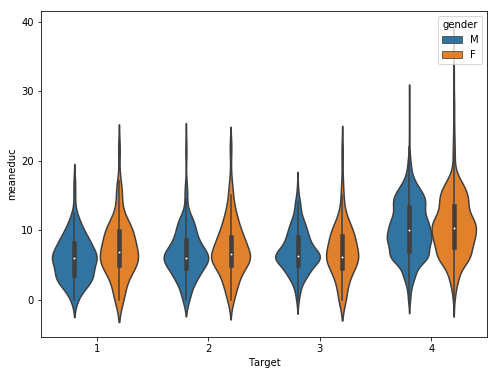

In [21]:
plt.figure(figsize = (8,6))
sns.violinplot(x = 'Target', y = 'meaneduc',
               hue = 'gender', data = label_df);

`dependency`,`edjefe`,`edjefa`与`target`之间的联系

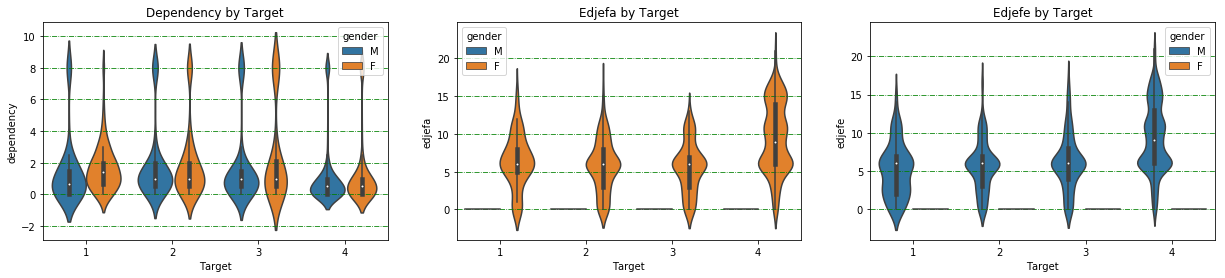

In [22]:
plt.figure(figsize = (21, 4))

# Iterate through the variables
for i, col in enumerate(['dependency', 'edjefa', 'edjefe']):
    ax = plt.subplot(1, 3, i+ 1)
    # Violinplot colored by `Target`
    sns.violinplot(x = 'Target', y = col, ax = ax, data = label_df, hue = 'gender')
    plt.title('%s by Target'%col.capitalize())
    plt.grid(axis = 'y', color='green', linestyle='-.')

## Define Variable Categories


在进行数据聚合之前，还要对特征变量分类(参考特征描述：feature_desp)

- 1.属于描述个人信息的特征
    - 布尔型
    - 连续型
- 2.描述家庭信息的特征
    - 布尔型
    - 连续型
- 3.id&target

# float类型

In [23]:
feature_desp.ix[list(train.select_dtypes(['float']).columns)]

,description
F_name,
v2a1,Monthly rent payment
v18q1,number of tablets household owns
rez_esc,Years behind in school
dependency,Dependency rate calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)
edjefe,years of education of male head of household based on the interaction of escolari (years of education) head of household and gender yes=1 and no=0
edjefa,years of education of female head of household based on the interaction of escolari (years of education) head of household and gender yes=1 and no=0
meaneduc,average years of education for adults (18+)
overcrowding,# persons per room
SQBovercrowding,overcrowding squared


In [24]:
# 这些特征在一个家庭中的情况'001ff74ca
indexs = list(train.select_dtypes(['float']).columns)
train.loc[train.idhogar == norm.index[5],indexs]

,v2a1,v18q1,rez_esc,dependency,edjefe,...,meaneduc,overcrowding,SQBovercrowding,SQBdependency,SQBmeaned
3775,180000.0,2.0,NaN,1.0,15.0,...,15.5,2.0,4.0,1.0,240.25
3776,180000.0,2.0,NaN,1.0,15.0,...,15.5,2.0,4.0,1.0,240.25
3777,180000.0,2.0,0.0,1.0,15.0,...,15.5,2.0,4.0,1.0,240.25
3778,180000.0,2.0,0.0,1.0,15.0,...,15.5,2.0,4.0,1.0,240.25


# int类型

int类型的特征较多，可以分为两类，布尔型（只有０/1)和非布尔型的．

In [25]:
# int 类型特征列名
int_cols = list(train.select_dtypes(['int']).columns)

# int类型，bool类型的特征列名
bool_cols = list(train[int_cols].nunique()[train[int_cols].nunique() == 2].index)

# int类型，non bool的特征列名
non_bool_cols = list(train[int_cols].nunique()[train[int_cols].nunique() !=2].index)

# elimbasu5是个特例，他是bool型的，只是在训练数据中，没有出现过１，全是０
non_bool_cols.remove('elimbasu5')
bool_cols.append('elimbasu5')

先看看non_bool_cols的特征描述信息

In [26]:
feature_desp.ix[non_bool_cols]

,description
F_name,
rooms,number of all rooms in the house
r4h1,Males younger than 12 years of age
r4h2,Males 12 years of age and older
r4h3,Total males in the household
r4m1,Females younger than 12 years of age
r4m2,Females 12 years of age and older
r4m3,Total females in the household
r4t1,persons younger than 12 years of age
r4t2,persons 12 years of age and older


In [27]:
# 具体到一个家庭的情况
pd.options.display.max_columns = 15
train.loc[train.idhogar == norm.index[5], non_bool_cols[:15]]

,rooms,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,hhsize,hogar_nin
3775,4,1,1,2,1,1,2,2,2,4,4,4,15,4,2
3776,4,1,1,2,1,1,2,2,2,4,4,4,16,4,2
3777,4,1,1,2,1,1,2,2,2,4,4,4,2,4,2
3778,4,1,1,2,1,1,2,2,2,4,4,4,4,4,2


In [28]:
train.loc[train.idhogar == norm.index[5], non_bool_cols[15:24]]

,hogar_adul,hogar_mayor,hogar_total,bedrooms,qmobilephone,age,SQBescolari,SQBage,SQBhogar_total
3775,2,0,4,2,2,39,225,1521,16
3776,2,0,4,2,2,36,256,1296,16
3777,2,0,4,2,2,8,4,64,16
3778,2,0,4,2,2,11,16,121,16


In [29]:
train.loc[train.idhogar == norm.index[5], non_bool_cols[24:]]

,SQBedjefe,SQBhogar_nin,agesq,Target
3775,225,4,1521,4
3776,225,4,1296,4
3777,225,4,64,4
3778,225,4,121,4


总结一下：个人特征：escolari,age,SQBescolari,SQBage,agesq,剩余的为家庭的特征

bool类型的int类型的特征

In [30]:
feature_desp.ix[bool_cols[:30]]

,description
F_name,
hacdor,=1 Overcrowding by bedrooms
hacapo,=1 Overcrowding by rooms
v14a,=1 has bathroom in the household
refrig,=1 if the household has refrigerator
v18q,owns a tablet
paredblolad,=1 if predominant material on the outside wall is block or brick
paredzocalo,=1 if predominant material on the outside wall is socket wood zinc or absbesto
paredpreb,=1 if predominant material on the outside wall is prefabricated or cement
pareddes,=1 if predominant material on the outside wall is waste material


In [31]:
feature_desp.ix[bool_cols[30:60]]

,description
F_name,
coopele,=1 electricity from cooperative
sanitario1,=1 no toilet in the dwelling
sanitario2,=1 toilet connected to sewer or cesspool
sanitario3,=1 toilet connected to septic tank
sanitario5,=1 toilet connected to black hole or letrine
sanitario6,=1 toilet connected to other system
energcocinar1,=1 no main source of energy used for cooking (no kitchen)
energcocinar2,=1 main source of energy used for cooking electricity
energcocinar3,=1 main source of energy used for cooking gas


In [32]:
feature_desp.ix[bool_cols[60:]]

,description
F_name,
estadocivil4,=1 if divorced
estadocivil5,=1 if separated
estadocivil6,=1 if widow/er
estadocivil7,=1 if single
parentesco1,=1 if household head
parentesco2,=1 if spouse/partner
parentesco3,=1 if son/doughter
parentesco4,=1 if stepson/doughter
parentesco5,=1 if son/doughter in law


# (object)类型

In [33]:
feature_desp.loc[['dependency','edjefe','edjefa']]

,description
F_name,
dependency,Dependency rate calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)
edjefe,years of education of male head of household based on the interaction of escolari (years of education) head of household and gender yes=1 and no=0
edjefa,years of education of female head of household based on the interaction of escolari (years of education) head of household and gender yes=1 and no=0


### fix testset `dependency`,`edjefe`,`edfefa`

对测试数据的`dependency`,`edjefe`,`edjefa`进行处理．

In [36]:
test.dependency = test.dependency.replace({"yes": 1, "no": 0}).astype(np.float64)
test.edjefa = test.edjefa.replace({"yes": 1, "no": 0}).astype(np.float64)
test.edjefe = test.edjefe.replace({"yes": 1, "no": 0}).astype(np.float64)

In [304]:
train.to_csv('../fix_train.csv',index = False)

In [305]:
test.to_csv('../fix_test.csv',index = False)